# Importing modules

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from nca_implementation.torchnca import nca
import matplotlib.pyplot as plt
import numpy as np

# Loading data

In [2]:
# Read pickles
df_m67 = pd.read_pickle('./data/oc_Messier_67_candidates.pickle')
df_m44 = pd.read_pickle('./data/oc_Messier_44_candidates.pickle')

# Filter based on fidelity_v2 >= 0.7
df_m67 = df_m67[df_m67['fidelity_v2'] >= 0.7]
df_m44 = df_m44[df_m44['fidelity_v2'] >= 0.7]

# Select only relevant columns
SELECTED_COLS = ['ra', 'dec', 'pmra', 'pmdec', 'r_med_geo', 'fidelity_v2', 'cluster_flag'] 
df_m67 = df_m67[SELECTED_COLS]
df_m44 = df_m44[SELECTED_COLS]

# Set cluster candidate information
"""
0 - M67_NOCLUSTER
1 - M67_CLUSTER
2 - M44_NOCLUSTER
3 - M44_CLUSTER
"""
df_m67.loc[df_m67.cluster_flag == 0, 'cluster_flag'] = 0
df_m67.loc[df_m67.cluster_flag == 1, 'cluster_flag'] = 1

df_m44.loc[df_m44.cluster_flag == 0, 'cluster_flag'] = 2
df_m44.loc[df_m44.cluster_flag == 1, 'cluster_flag'] = 3

# Join the data
df = pd.concat([df_m67, df_m44])

In [3]:
print("-------- Messier-67 Cluster Flag Counts --------")
print(df_m67['cluster_flag'].value_counts())

print()

print("-------- Messier-44 Cluster Flag Counts --------")
print(df_m44['cluster_flag'].value_counts())

-------- Messier-67 Cluster Flag Counts --------
cluster_flag
0    86737
1      974
Name: count, dtype: int64

-------- Messier-44 Cluster Flag Counts --------
cluster_flag
2    83565
3      679
Name: count, dtype: int64


In [4]:
print("-------- COLUMN INFORMATION --------")
df.info()

-------- COLUMN INFORMATION --------
<class 'pandas.core.frame.DataFrame'>
Index: 171955 entries, 1 to 110831
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ra            171955 non-null  float64
 1   dec           171955 non-null  float64
 2   pmra          171955 non-null  float64
 3   pmdec         171955 non-null  float64
 4   r_med_geo     171955 non-null  float32
 5   fidelity_v2   171955 non-null  float32
 6   cluster_flag  171955 non-null  int64  
dtypes: float32(2), float64(4), int64(1)
memory usage: 9.2 MB


In [5]:
df.head()

,ra,dec,pmra,pmdec,r_med_geo,fidelity_v2,cluster_flag
1,132.460820,9.354456,-4.467221,11.077062,1299.076538,0.989258,0
2,132.447898,9.347820,-20.515164,5.789698,259.710754,1.000000,0
3,132.422902,9.353250,-11.516026,-1.922608,538.822510,0.993164,0
4,132.399934,9.357089,-5.521866,-9.747638,1644.195190,0.965820,0
5,132.413950,9.358508,-2.926452,5.010006,844.427246,0.966797,0


# Train-test split

In [6]:
# Selecting 30 rows at random
# df = df.loc[~df['cluster_flag'].isin([1, 3])].sample(n=30, random_state=42)

# Splitting into features (X) and labels (y)
X = torch.tensor(df.drop(labels=['cluster_flag'], axis=1).values, dtype=torch.float32)
y = torch.tensor(df['cluster_flag'].copy().values)

poly = PolynomialFeatures(3, include_bias=False, interaction_only=True)

X = torch.tensor(poly.fit_transform(X), dtype=torch.float32)

# Stratified Train-test split (based on labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define where computations will take place (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move train data to device
X_train.to(device)
y_train.to(device)

tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0')

In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([137564, 41]) torch.Size([137564]) torch.Size([34391, 41]) torch.Size([34391])


In [8]:
print("-------- TRAIN DATASET LABEL PERCENTAGES --------")
y_train_uniques, y_train_unique_counts = y_train.unique(return_counts=True)
y_train_total = torch.sum(y_train_unique_counts).item()

for item, count in zip(y_train_uniques, y_train_unique_counts):
    print(f"{item}: {(count / y_train_total) * 100:.4f}%")

print("Total Samples: " + str(y_train_total))

print()

print("-------- TEST DATASET LABEL PERCENTAGES --------")
y_test_uniques, y_test_unique_counts = y_test.unique(return_counts=True)
y_test_total = torch.sum(y_test_unique_counts).item()

for item, count in zip(y_test_uniques, y_test_unique_counts):
    print(f"{item}: {(count / y_test_total) * 100:.4f}%")

print("Total Samples: " + str(y_test_total))

-------- TRAIN DATASET LABEL PERCENTAGES --------
0: 50.4420%
1: 0.5663%
2: 48.5970%
3: 0.3947%
Total Samples: 137564

-------- TEST DATASET LABEL PERCENTAGES --------
0: 50.4405%
1: 0.5670%
2: 48.5970%
3: 0.3955%
Total Samples: 34391


In [17]:
torch.autograd.set_detect_anomaly(False)
nca_pipeline = nca.NCANonlinear(dim=2, max_iters=200)
nca_pipeline.train(X_train, y_train, batch_size=256, weight_decay=1e-3, lr=1e-2, momentum=1e-4)

using random init
epoch: 1 - loss: 304.89600
epoch: 1 - loss: 320.73041
epoch: 1 - loss: 347.48523
epoch: 1 - loss: 329.76135
epoch: 1 - loss: 319.71753
epoch: 1 - loss: 319.67929
epoch: 1 - loss: 319.62415
epoch: 1 - loss: 341.28296
epoch: 1 - loss: 320.02606
epoch: 1 - loss: 332.22412
epoch: 1 - loss: 318.53888
epoch: 1 - loss: 306.18060
epoch: 1 - loss: 325.05298
epoch: 1 - loss: 314.62134
epoch: 1 - loss: 317.99231
epoch: 1 - loss: 303.05969
epoch: 1 - loss: 304.91656
epoch: 1 - loss: 304.46204
epoch: 1 - loss: 315.92993
epoch: 1 - loss: 315.37091
epoch: 1 - loss: 304.50299
epoch: 2 - loss: 304.26572
epoch: 2 - loss: 338.88574
epoch: 2 - loss: 320.08493
epoch: 2 - loss: 320.54312
epoch: 2 - loss: 314.70117
epoch: 2 - loss: 303.69498
epoch: 2 - loss: 336.36240
epoch: 2 - loss: 318.93030
epoch: 2 - loss: 301.84949
epoch: 2 - loss: 303.67548
epoch: 2 - loss: 299.52707
epoch: 2 - loss: 315.32086
epoch: 2 - loss: 301.81723
epoch: 2 - loss: 315.15521
epoch: 2 - loss: 302.13403
epoch: 2 -

In [25]:
torch.autograd.set_detect_anomaly(False)
nca_pipeline = nca.NCALinear(dim=2, max_iters=50)
nca_pipeline.train(X_train, y_train, batch_size=256, weight_decay=1e-3, lr=1e-4, momentum=1e-4)

using random init
epoch: 1 - loss: 301.19977, classification loss: 178.48218, hinge loss: 122.71761
epoch: 1 - loss: 297.55371, classification loss: 178.04427, hinge loss: 119.50946
epoch: 1 - loss: 312.03485, classification loss: 189.82512, hinge loss: 122.20974
epoch: 1 - loss: 297.40543, classification loss: 178.47920, hinge loss: 118.92622
epoch: 1 - loss: 298.14514, classification loss: 178.29660, hinge loss: 119.84854
epoch: 1 - loss: 322.51129, classification loss: 200.77545, hinge loss: 121.73583
epoch: 1 - loss: 327.81171, classification loss: 204.44481, hinge loss: 123.36689
epoch: 1 - loss: 294.49371, classification loss: 177.08191, hinge loss: 117.41179
epoch: 1 - loss: 294.62799, classification loss: 177.40384, hinge loss: 117.22416
epoch: 1 - loss: 323.61865, classification loss: 201.07913, hinge loss: 122.53951
epoch: 1 - loss: 319.45184, classification loss: 200.04855, hinge loss: 119.40331
epoch: 1 - loss: 317.41272, classification loss: 196.56763, hinge loss: 120.8451

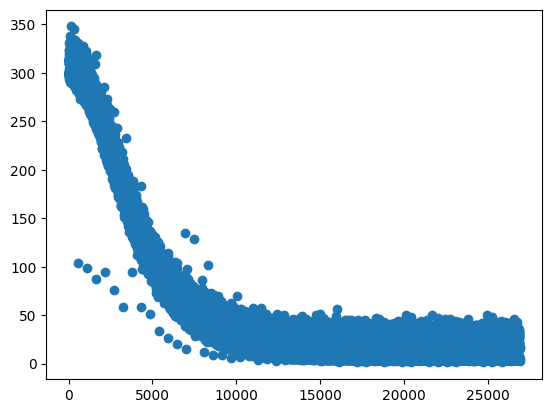

In [26]:
plt.scatter(range(len(nca_pipeline.losses)), nca_pipeline.losses)

In [27]:
print("Max Loss: " + str(max(nca_pipeline.losses)))
print("Min Loss: " + str(min(nca_pipeline.losses)))

Max Loss: 347.8916320800781
Min Loss: 1.172802209854126


In [28]:
nca_pipeline.A.shape

torch.Size([2, 41])

[[-0.19703174  0.26522774  0.01811741  0.0116965  -0.02424613 -0.03087454
   0.25863138  0.00978883  0.01405873 -0.04231014 -0.06472457  0.01960996
  -0.01494557  0.03208756  0.23848738  0.00350914  0.01595877  0.01226529
  -0.00328311  0.01942969 -0.02604591  0.00861906 -0.00209447  0.06197275
   0.2521192   0.01029161  0.00181226  0.01508614 -0.00061185  0.0053567
  -0.01755379  0.00319464 -0.02162093  0.00178927 -0.02852659 -0.02445603
   0.06458896  0.02200381  0.01320873  0.00960911  0.01947393]
 [-0.18032227  0.27604082 -0.00878213  0.01616675 -0.02583145 -0.02829095
   0.2854702   0.00790457  0.02153048 -0.03554625 -0.06715252 -0.03275247
  -0.01601057  0.02805951  0.25107965 -0.010684    0.01993034  0.00999894
   0.01104347 -0.00100372 -0.02861213 -0.03376635 -0.02718722  0.03170612
   0.26009047 -0.01588588  0.0016062  -0.00147687  0.00949787  0.00276073
  -0.04032153 -0.00736524 -0.02387269 -0.03312147 -0.01410205 -0.00761997
   0.04252679 -0.0159061  -0.0056719   0.00382644 

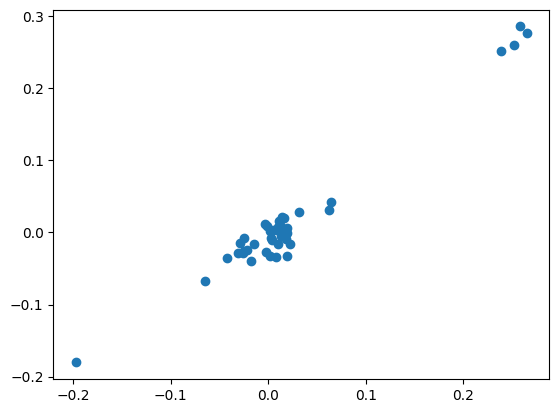

In [29]:
A = nca_pipeline.A.detach().cpu()

print(A.numpy())

plt.scatter(A.numpy()[0], A.numpy()[1])

In [30]:
# Transform the train datasets
X_train_transformed = nca_pipeline(X_train)

# Move the train data back to CPU
X_train_transformed = X_train_transformed.detach().cpu()
y_train = y_train.detach().cpu()

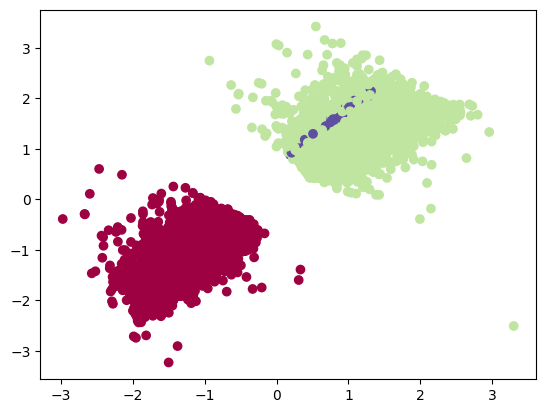

In [31]:
n_train = X_train_transformed.shape[0]
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=y_train, cmap=plt.cm.Spectral)

In [ ]:
with open('data/pij.mtx', 'w') as file:
    file.write('%%MatrixMarket matrix coordinate double symmetric\n')
    # file.write('%%MatrixMarket matrix coordinate pattern symmetric\n')
    file.write('%pij graph for SDP community detection\n')
    file.write(f"{N} {N} {M}\n")

    for i in range(N):
        for j in range(i, N):
            if pij_X_train[i][j] >= 4:
                file.write(f"{i + 1} {j + 1} {pij_X_train[i][j]}")
                # file.write(f"{i + 1} 5 {i}")
                # file.write(f"{i + 1} 5")
                if (i != N - 1 or j != N - 1): file.write("\n")

In [ ]:
def pairwise_l2_sq(x, y):
    dot = torch.mm(x.double(), torch.t(y.double()))
    left_norms = torch.pow(torch.norm(x, p=2, dim=1), 2)[:, None]
    right_norms = torch.pow(torch.norm(y, p=2, dim=1), 2)[None, :]
    dist = left_norms - 2 * dot + right_norms
    dist = torch.clamp(dist, min=0)
    return dist.float()

i = 0
N = len(X_train_transformed)
lines = []

while i < N:
    j = min(i + 100, N)
    
    X_train_transformed_slice = X_train_transformed[i:j]
    if X_train_transformed_slice.ndim == 1:
        X_train_transformed_slice = X_train_transformed_slice[None, :]

    lengths = pairwise_l2_sq(X_train_transformed_slice, X_train_transformed)
    
    if (torch.any(torch.isnan(lengths))):
        print("---- NAN detected in 'lengths' variable")
        raise Exception()

    mesh_x, mesh_y = torch.meshgrid(torch.arange(i, j), torch.arange(N), indexing='ij')
    mask = mesh_x == mesh_y
    lengths[mask] = np.inf

    exp = torch.exp(-lengths)
    sums = exp.sum(dim=1)[:, None]
    sums += 0.01
    p_ij = (exp / sums) * (10 ** 8)

    for r in range(0, j - i):
        for c in range(N):
            if p_ij[r][c] >= 3100:
                lines.append(f"{r + i + 1} {c + 1} {p_ij[r][c].item()}\n")
            
                if len(lines) >= 100:
                    with open('OUTPUT-MAIN.txt', 'a') as f:
                        f.writelines(lines)
                    lines = []

    
    i += 100



KeyboardInterrupt: 

In [ ]:
y_train[:10]